# Proposal for Revised 2020 FIA Formula One Calender

Import Dependencies

In [1]:
import requests # library to handle requests

#Web Scraping
import urllib.request, urllib.parse, urllib.error
from bs4 import BeautifulSoup as bs

#Data Wrangling
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#Data Visualistion
from matplotlib import pyplot
import matplotlib.pyplot as plt
import folium # map rendering library

#Machine Learning Libraries
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs
from sklearn import linear_model

C:\Users\gajones\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


## Original 2020 Calender

### Use information regarding the original 2020 F1 Calender

In [3]:
# scrape calender information from Wikipedia
url2020 = 'https://en.wikipedia.org/wiki/2020_Formula_One_World_Championship'
html = urllib.request.urlopen(url2020).read()

# parse using BeautifulSoup 
phtml = bs(html,'html.parser')

# Initialise features
races = []
circuits = []
cities = []
countries = []
schedule = []

Parse table of races already postponed in 2020 - assign a 'schedule' value of 0

In [4]:
table_postponed = phtml.find_all('table')[3]
rows = table_postponed.find_all('tr')

for tr in rows:
    td = tr.find_all('td')
    row = [i.text for i in td]
    if len(row) == 5:
        temp = row[1].strip().split(',')
        races.append(row[0].strip())
        circuits.append(temp[0])
        cities.append(temp[1])
        schedule.append(0)
        
span = table_postponed.find_all('span',class_='flagicon')
for s in span:
    tests = s.find('a')
    countries.append(tests.get('title',None))  

Parse table of races still scheduled in 2020 - assign a 'schedule' value of 1

In [6]:
table_scheduled = phtml.find_all('table')[2]
rows = table_scheduled.find_all('tr')

for tr in rows:
    td = tr.find_all('td')
    row = [i.text for i in td]
    if len(row) == 3:
        temp = row[1].strip().split(',')
        races.append(row[0].strip())
        circuits.append(temp[0])
        cities.append(temp[1])
        schedule.append(1)
        
span = table_scheduled.find_all('span',class_='flagicon')
for s in span:
    tests = s.find('a')
    countries.append(tests.get('title',None))  

Loop through 2020 calender information and obtain GeoLocation of all races

In [7]:
latitudes = []
longitudes = []
for i in range(0,len(circuits)):
    try:
        address =  circuits[i]
        geolocator = Nominatim(user_agent="race_checker")
        location = geolocator.geocode(address)
        latitudes.append(location.latitude)
        longitudes.append(location.longitude)
    except:
        if 'Stavelot' in cities[i]:
            address =  'Route du Circuit'
            geolocator = Nominatim(user_agent="race_checker")
            location = geolocator.geocode(address)
            latitudes.append(location.latitude)
            longitudes.append(location.longitude)        
        elif 'Suzuka' in cities[i]:
            address =  'Suzuka Circuit'
            geolocator = Nominatim(user_agent="race_checker")
            location = geolocator.geocode(address)
            latitudes.append(location.latitude)
            longitudes.append(location.longitude)
        else:
            address =  cities[i]
            geolocator = Nominatim(user_agent="race_checker")
            location = geolocator.geocode(address)
            latitudes.append(location.latitude)
            longitudes.append(location.longitude)

### Build a dataframe of orignal 2020 Calender information

In [8]:
headers = ['Country','Grand Prix','Circuit','Location','Schedule','Latitude','Longitude']
df = pd.DataFrame(list(zip(countries, races, circuits, cities, schedule, latitudes, longitudes)), columns = headers)
df.head()

,Country,Grand Prix,Circuit,Location,Schedule,Latitude,Longitude
0,Australia,Australian Grand Prix,Albert Park Circuit,Melbourne,0,-37.841353,144.963743
1,Bahrain,Bahrain Grand Prix,Bahrain International Circuit,Sakhir,0,26.028603,50.510336
2,Vietnam,Vietnamese Grand Prix,Hanoi Street Circuit,Hanoi,0,21.017009,105.764044
3,China,Chinese Grand Prix,Shanghai International Circuit,Shanghai,0,31.339979,121.219598
4,Netherlands,Dutch Grand Prix,Circuit Zandvoort,Zandvoort,0,52.382273,4.533707


## Investigate the distribution of Grand Prix around the world

### Transform the continuous coordinate data into categorical data based on Hemishpere

In [10]:
#define bins with bin edge at Equator (Latitude of 0)
bins = np.linspace(-180, 180, 3)
group_names = ['Southern','Northern']

#Use 'cut' function to define regions
df['Region'] = pd.cut(df['Latitude'], bins, labels = group_names, include_lowest = True )

In [11]:
#Group the regions together
df_region = df[['Region']]
df_group = pd.DataFrame(df_region['Region'].value_counts())

Text(0.5, 1.0, 'Distribution of Grand Prix by Global Region')

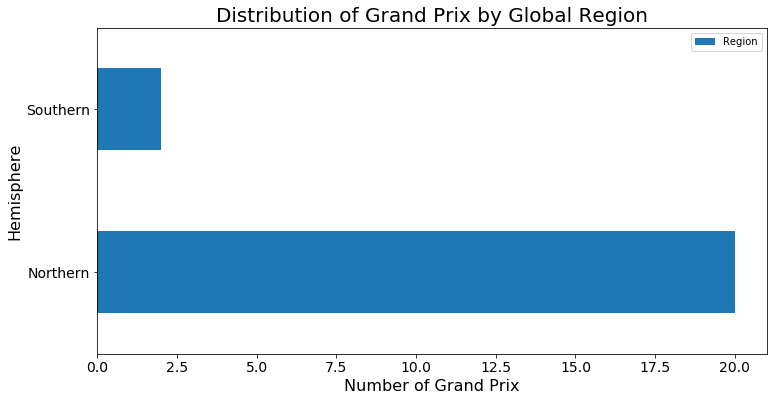

In [13]:
#produce bar plot to visualise distribution of Grand Prix
df_group.plot(kind='barh', fontsize=14, figsize=(12, 6))
plt.ylabel('Hemisphere',fontsize=16) # add to x-label to the plot
plt.xlabel('Number of Grand Prix',fontsize=16) # add y-label to the plot
plt.title('Distribution of Grand Prix by Global Region',fontsize=20) # add title to the plot

### Map of Original 2020 Calender

In [16]:
map_world = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()],zoom_start=2)

g1 = folium.FeatureGroup(name='<span style=\\"color: #cc3131;\\">Postponed</span>')
g2 = folium.FeatureGroup(name='<span style=\\"color: #0cc913;\\">Scheduled</span>')

In [105]:
for lat, lng, grandprix, schedule in zip(df['Latitude'], df['Longitude'], df['Grand Prix'], df['Schedule']):
    label = '{}'.format(grandprix)
    label = folium.Popup(label, parse_html=True)
    if schedule != 1:
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color='#cc3131',
            fill=True,
            fill_color='#f59c78',
            fill_opacity=0.7,
            parse_html=False).add_to(g1)  
        
    else:
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color='#0cc913',
            fill=True,
            fill_color='#5fba62',
            fill_opacity=0.7,
            parse_html=False).add_to(g2)   

g1.add_to(map_world)        
g2.add_to(map_world)        

folium.map.LayerControl('topright', collapsed=False).add_to(map_world)  

In [106]:
map_world

### Cluster races using K-means

In [20]:
# Create numpy array from coordinates
X = np.column_stack((list(df['Longitude']), list(df['Latitude'])))

In [22]:
#Perform k-means clustering
k_means = KMeans(init = "k-means++", n_clusters = 4, n_init = 12)
k_means.fit(X)

k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_

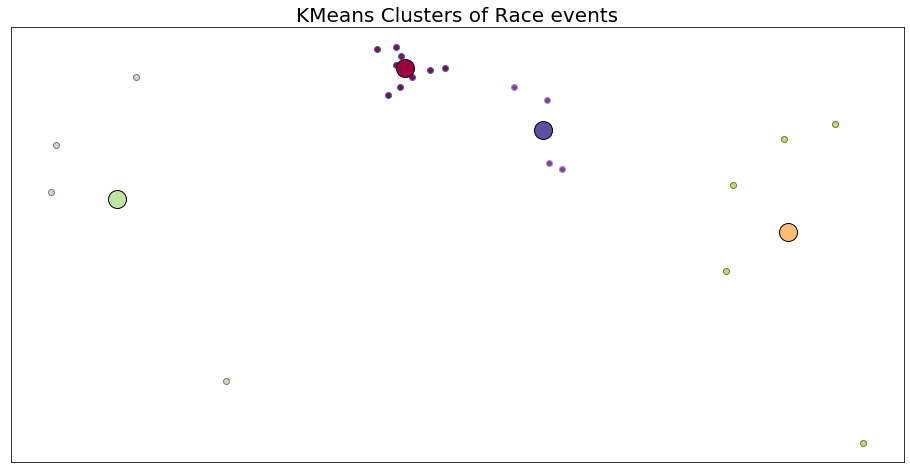

In [24]:
#Plot clusters and their centres
fig = plt.figure(figsize=(16, 8))

# Colors uses a color map, which will produce an array of colors based on
# the number of labels there are. We use set(k_means_labels) to get the
# unique labels.
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

# Create a plot
ax = fig.add_subplot(1, 1, 1)

# For loop that plots the data points and centroids.
# k will range from 0-3, which will match the possible clusters that each
# data point is in.
for k, col in zip(range(len([[4,4], [-2, -1], [2, -3], [1, 1]])), colors):

    # Create a list of all data points, where the data poitns that are 
    # in the cluster (ex. cluster 0) are labeled as true, else they are
    # labeled as false.
    my_members = (k_means_labels == k)
    
    # Define the centroid, or cluster center.
    cluster_center = k_means_cluster_centers[k]
    
    # Plots the datapoints with color col.
    ax.plot(X[my_members, 0], X[my_members, 1], 'o', markerfacecolor=col, marker='.', markersize=12)
    
    # Plots the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=18)

# Title of the plot
ax.set_title('KMeans Clusters of Race events', fontsize = 20)

# Remove x-axis ticks
ax.set_xticks(())

# Remove y-axis ticks
ax.set_yticks(())

# Show the plot
plt.show()

## Data Acquisition

### Which races had the highest attendance in 2019?

In [25]:
total_att = [324100,97000,160428,85000,307000,160000,203000,351000,
             230000,251864,200000,202146,268000,345694]
countries_att = ['Australia', 'Bahrain', 'Spain', 'Azerbaijan', 'Canada', 'France', 'Austria',
 'United Kingdom', 'Hungary', 'Belgium', 'Italy', 'Japan', 'United States', 'Mexico']

total_att_append = []

In [26]:
for country in df['Country']:
    count = 0  
    for att in countries_att:
        if att == country:
            C = country
            T = total_att[count]
            count = count + 1
            break
        else:
            C = country
            T = np.nan        
            count = count + 1
    total_att_append.append(T)

In [27]:
df['Attendance'] = list(map(float,total_att_append))

create sub-data frame for plotting results

In [36]:
# DataFrame containing host countries and attendences
df_att = df[['Country', 'Attendance']].copy()
df_att['Attendance'] = list(map(float,df_att['Attendance']))
df_att['Country'] = list(map(str,df_att['Country']))

In [37]:
df_att = df_att.set_index('Country')
df_att.sort_values(['Attendance'], ascending=False, axis=0, inplace=True)

Text(0.5, 0, 'Country')

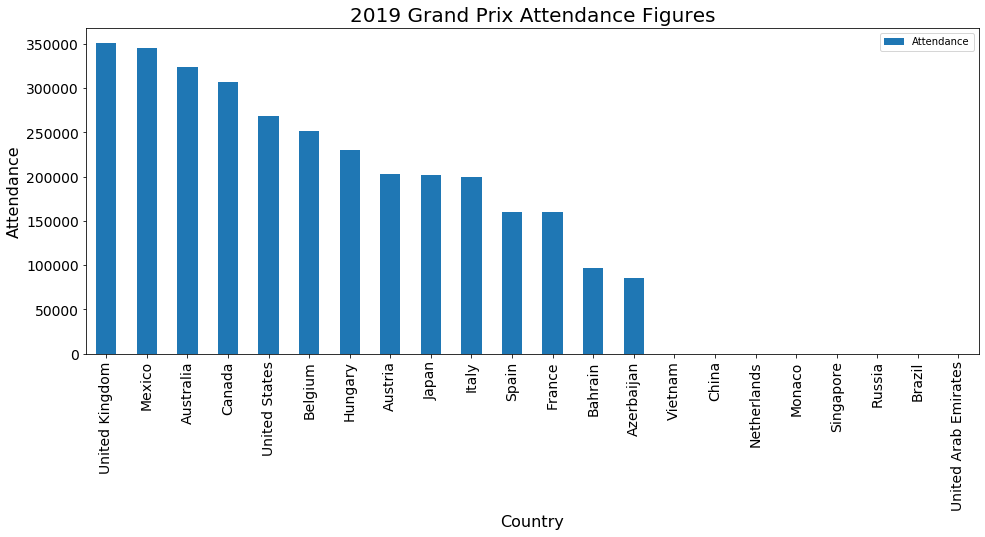

In [38]:
df_att.plot(kind='bar', fontsize=14, figsize=(16, 6))
plt.title('2019 Grand Prix Attendance Figures',fontsize=20)
plt.ylabel('Attendance',fontsize=16)
plt.xlabel('Country',fontsize=16)

### Which circuit is the most popular on FourSquare

In [49]:
# FourSquare Credentials
CLIENT_ID = 'G4FHOQGQ2YXF42EBT03IADNROE0WDDZDFOLG54RYX2U0E1SY' # your Foursquare ID
CLIENT_SECRET = 'FUZNZUIRWHC0EG1JXNZA22MLSPEK33TL0B3XMYI1GGDTSUIY' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 50

Generate URLs using Latitude/Longtiude data found earlier in the notebook

Search for 'Formula 1' at those locations

In [50]:
search_query = 'Formula 1'
radius = 15000
urls = [];
count = 0
for circuit in circuits:
    urls.append('https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, df.iloc[count,5], df.iloc[count,6], VERSION, search_query, radius, LIMIT))
    count = count + 1

In [51]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Loop through the list of URLs created above and interrogate the locations with 'Formula 1' tags

If locations have a category 'racetrack' then find out how many photos and 'likes' have been posted there

In [52]:
engagement = []
for url in urls:
    try:
        results = requests.get(url).json()
        venues = results['response']['venues']
        dataframe = json_normalize(venues)
        
        filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
        dataframe_filtered = dataframe.loc[:, filtered_columns]
        
        dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
        
        dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
        
        count = 0
        sum_engagement = 0
        for category in dataframe_filtered.categories:
            cat = str(category).lower()
            if cat == 'racetrack':
                venue_id = dataframe_filtered.id[count]
                url_id = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
                result_id = requests.get(url_id).json()
                
                try:
                    L = result_id['response']['venue']['likes']['count']
                except:
                    continue
                    
                try:
                    P = result_id['response']['venue']['photos']['count']
                except:
                    continue
                
                id_engagement = int(L) + int(P)
                sum_engagement = sum_engagement + id_engagement
                count = count + 1
            else:
                count = count + 1 
        engagement.append(sum_engagement)
    except:
        engagement.append(np.nan)

C:\Users\gajones\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [53]:
df['Engagement'] = engagement

create sub-data frame for plotting results

In [54]:
# DataFrame containing host countries and fan engagement
df_engage = df[['Country', 'Engagement']].copy()
df_engage['Engagement'] = list(map(int,df_engage['Engagement']))
df_engage['Country'] = list(map(str,df_engage['Country']))

In [55]:
df_engage = df_engage.set_index('Country')
df_engage.sort_values(['Engagement'], ascending=False, axis=0, inplace=True)

Text(0.5, 1.0, 'Fan Engagement by country on the current F1 Calender')

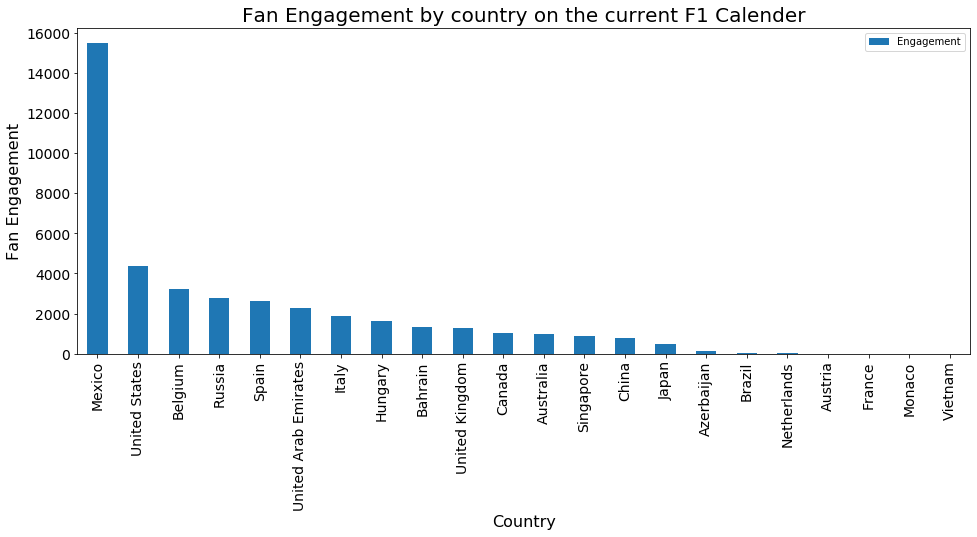

In [56]:
df_engage.plot(kind='bar', fontsize=14, figsize=(16, 6))
plt.xlabel('Country',fontsize=16)
plt.ylabel('Fan Engagement',fontsize=16)
plt.title('Fan Engagement by country on the current F1 Calender',fontsize=20)

## Regression Analysis

In [57]:
regr = linear_model.LinearRegression()

In [58]:
# Append engagement sub-data frame with attendacnce figures so the two variables can be correlated
df_engage['Attendance'] = df_att['Attendance']
df_engage.columns = ['ENGAGEMENT','ATTENDANCE']

For the regression analysis missing data and outliers will be removed

In [59]:
df_engage.replace(0, np.nan, inplace = True)

df_engage.dropna(inplace=True)
df_engage.drop('Mexico',inplace=True)

In [ ]:
regr = linear_model.LinearRegression()

In [60]:
x = np.asanyarray(df_engage[['ENGAGEMENT']])
y = np.asanyarray(df_engage[['ATTENDANCE']])
regr.fit (x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Text(0.5, 1.0, 'Correlation of Fan Engagement to Race Attendance')

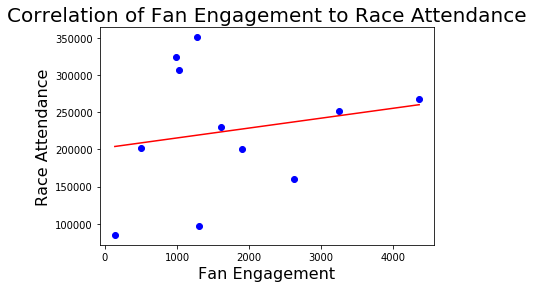

In [61]:
plt.scatter(df_engage.ENGAGEMENT, df_engage.ATTENDANCE,  color='blue')
plt.plot(x, regr.coef_[0][0]*x + regr.intercept_[0], '-r')
plt.xlabel("Fan Engagement", fontsize=16)
plt.ylabel("Race Attendance", fontsize=16)
plt.title("Correlation of Fan Engagement to Race Attendance", fontsize=20)

## Remove 4 races based on global distribution and Fan Engagement

In [62]:
df

,Country,Grand Prix,Circuit,Location,Schedule,Latitude,Longitude,Region,Attendance,Engagement
0,Australia,Australian Grand Prix,Albert Park Circuit,Melbourne,0,-37.841353,144.963743,Southern,324100.0,980
1,Bahrain,Bahrain Grand Prix,Bahrain International Circuit,Sakhir,0,26.028603,50.510336,Northern,97000.0,1308
2,Vietnam,Vietnamese Grand Prix,Hanoi Street Circuit,Hanoi,0,21.017009,105.764044,Northern,NaN,0
3,China,Chinese Grand Prix,Shanghai International Circuit,Shanghai,0,31.339979,121.219598,Northern,NaN,778
4,Netherlands,Dutch Grand Prix,Circuit Zandvoort,Zandvoort,0,52.382273,4.533707,Northern,NaN,14
5,Spain,Spanish Grand Prix,Circuit de Barcelona-Catalunya,Montmeló,0,41.569469,2.258063,Northern,160428.0,2629
6,Monaco,Monaco Grand Prix,Circuit de Monaco,Monte Carlo,0,48.264099,4.616128,Northern,NaN,0
7,Azerbaijan,Azerbaijan Grand Prix,Baku City Circuit,Baku,0,40.375443,49.832675,Northern,85000.0,138
8,Canada,Canadian Grand Prix,Circuit Gilles Villeneuve,Montréal,0,45.500103,-73.522715,Northern,307000.0,1032
9,France,French Grand Prix,Circuit Paul Ricard,Le Castellet,0,43.257544,5.780472,Northern,160000.0,0


In [70]:
df.set_index('Country',inplace=True)

In [71]:
df.drop(['Australia','Bahrain','Azerbaijan','Brazil'],inplace=True)

In [72]:
map_final = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()],zoom_start=2)

In [73]:
for lat, lng, grandprix, schedule in zip(df['Latitude'], df['Longitude'], df['Grand Prix'], df['Schedule']):
    label = '{}'.format(grandprix)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='#cc3131',
        fill=True,
        fill_color='#f59c78',
        fill_opacity=0.7,
        parse_html=False).add_to(map_final)  
map_final

In [102]:
# Create numpy array from coordinates
Xf = np.column_stack((list(df['Longitude']), list(df['Latitude'])))

In [103]:
k_means = KMeans(init = "k-means++", n_clusters = 5, n_init = 12)
k_means.fit(Xf)

k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_

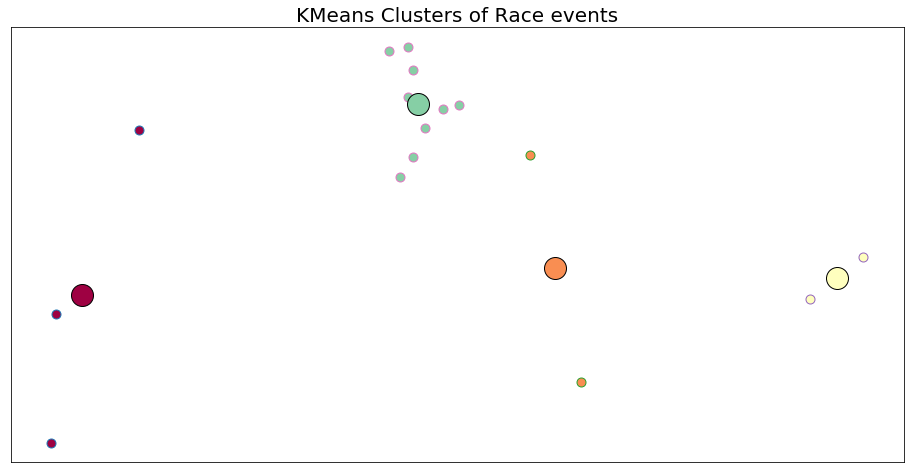

In [104]:
# Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(16, 8))

# Colors uses a color map, which will produce an array of colors based on
# the number of labels there are. We use set(k_means_labels) to get the
# unique labels.
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

# Create a plot
ax = fig.add_subplot(1, 1, 1)

# For loop that plots the data points and centroids.
# k will range from 0-3, which will match the possible clusters that each
# data point is in.
for k, col in zip(range(len([[4,4], [-2, -1], [2, -3], [1, 1]])), colors):

    # Create a list of all data points, where the data poitns that are 
    # in the cluster (ex. cluster 0) are labeled as true, else they are
    # labeled as false.
    my_members = (k_means_labels == k)
    
    # Define the centroid, or cluster center.
    cluster_center = k_means_cluster_centers[k]
    
    # Plots the datapoints with color col.
    ax.plot(Xf[my_members, 0], Xf[my_members, 1], 'o', markerfacecolor=col, marker='.', markersize=18)
    
    # Plots the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=22)

# Title of the plot
ax.set_title('KMeans Clusters of Race events', fontsize = 20)

# Remove x-axis ticks
ax.set_xticks(())

# Remove y-axis ticks
ax.set_yticks(())

# Show the plot
plt.show()